In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
import xgboost as xgb

from utils import util_data

In [87]:
df = pd.read_csv("data/processed/df_lastN.csv")
df.head(3)

,oem,model,network_technology,network_2g_bands,network_gprs,network_edge,launch_announced,launch_status,body_dimensions,body_weight,...,camera,main_camera,network,battery_talk_time,battery_stand.by,px_width,px_height,display_ratio,gb_rom,gb_ram
0,Google,Pixel 4 XL,GSM / CDMA / HSPA / EVDO / LTE,GSM 850 / 900 / 1800 / 1900,NaN,NaN,2019,"Available. Released 2019, October 22",160.4 x 75.1 x 8.2 mm (6.31 x 2.96 x 0.32 in),193,...,NaN,NaN,CDMA 800 / 1900,NaN,NaN,1440.0,3040.0,19:9,64.0,6.0
1,Google,Pixel 4,GSM / CDMA / HSPA / EVDO / LTE,GSM 850 / 900 / 1800 / 1900,NaN,NaN,2019,"Available. Released 2019, October 22",147.1 x 68.8 x 8.2 mm (5.79 x 2.71 x 0.32 in),162,...,NaN,NaN,CDMA 800 / 1900,NaN,NaN,1080.0,2280.0,19:9,64.0,6.0
2,Google,Pixel 3a XL,GSM / CDMA / HSPA / EVDO / LTE,GSM 850 / 900 / 1800 / 1900,NaN,NaN,2019,"Available. Released 2019, May 15",160.1 x 76.1 x 8.2 mm (6.30 x 3.00 x 0.32 in),167,...,NaN,NaN,CDMA 800 / 1900,NaN,NaN,1080.0,2160.0,18:9,64.0,4.0


In [88]:
dup_cols = ["display_type", "display_size", "memory_card_slot", "sound_loudspeaker", "sound_3.5mm_jack", "comms_wlan", "misc_price", "comms_nfc", "px_width", "px_height", "gb_rom", "gb_ram"]
all_cols = ["oem", "model", "display_type", "display_size", "memory_card_slot", "sound_loudspeaker", "sound_3.5mm_jack", "comms_wlan", "misc_price", "comms_nfc", "px_width", "px_height", "gb_rom", "gb_ram"]

# show duplicated rows
df[all_cols][df.duplicated(keep=False, subset=dup_cols)].sort_values(by=dup_cols)

,oem,model,display_type,display_size,memory_card_slot,sound_loudspeaker,sound_3.5mm_jack,comms_wlan,misc_price,comms_nfc,px_width,px_height,gb_rom,gb_ram
755,Lenovo,Vibe A,LCD,4.00,YES,Mono,Yes,Mono,50.0,NO,480.0,800.0,4.0,0.5
859,Micromax,Bharat 2 Q402,LCD,4.00,YES,Mono,Yes,Mono,50.0,NO,480.0,800.0,4.0,0.5
488,BLU,Advance L4,LCD,4.00,YES,Mono,Yes,Mono,50.0,NO,480.0,800.0,8.0,0.5
492,BLU,C4,LCD,4.00,YES,Mono,Yes,Mono,50.0,NO,480.0,800.0,8.0,0.5
750,Lenovo,A Plus,LCD,4.50,YES,Mono,Yes,Mono,70.0,NO,480.0,854.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,Huawei,P40 lite E,LCD,6.39,YES,Mono,Yes,Mono,160.0,NO,720.0,1560.0,64.0,4.0
1027,Samsung,Galaxy J4,OLED,5.50,YES,Mono,Yes,Mono,140.0,NO,720.0,1280.0,16.0,2.0
1288,ZTE,Blade A910,OLED,5.50,YES,Mono,Yes,Mono,140.0,NO,720.0,1280.0,16.0,2.0
272,Xiaomi,Mi 9 Pro,OLED,6.39,NO,Mono,No,Dual,500.0,YES,1080.0,2340.0,128.0,8.0


In [89]:
keep_cols = ["display_type", "display_size", "memory_card_slot", "sound_loudspeaker", "sound_3.5mm_jack", "comms_wlan", "misc_price", "comms_nfc", "px_width", "px_height", "gb_rom", "gb_ram"]

df = df[keep_cols].dropna().drop_duplicates().reset_index(drop=True)

In [90]:
print(f"Null values:{df.isna().sum().sum()}")
print(f"Number of duplicated rows: {df.duplicated().sum()}")

print(f"Number of rows: {df.shape[0]}")

Null values:0
Number of duplicated rows: 0
Number of rows: 1159


Binary categorization of Yes/No features

In [91]:
yes_no_cols = ["memory_card_slot", "sound_3.5mm_jack", "comms_nfc"]

# transform yes_no_cols to 0/1
for col in yes_no_cols:
    df[col] = df[col].str.lower().map({"yes": 1, "no": 0})

Binary categorization of categorical features

In [92]:
bin_cols = ["comms_wlan", "display_type", "sound_loudspeaker"]

label_bins = {}
for col in bin_cols:
    label_bins[col] = LabelBinarizer()
    df[col] = label_bins[col].fit_transform(df[col])

Standardization of numerical features

In [93]:
num_cols = ["display_size", "gb_ram", "gb_rom", "px_height", "px_width"]

scaler_num = {}
for col in num_cols:
    scaler_num[col] = StandardScaler()
    df[col] = scaler_num[col].fit_transform(df[col].values.reshape(-1, 1))

Price distribution

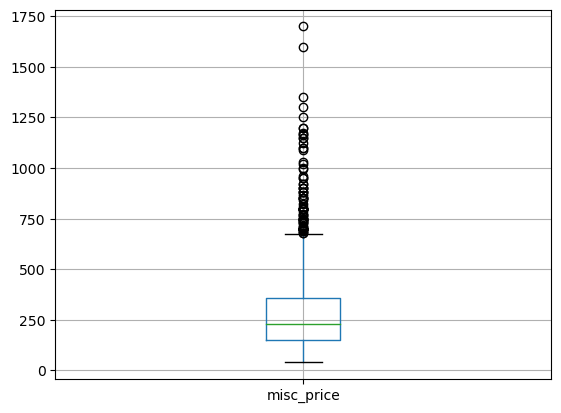

In [94]:
df.boxplot(column=["misc_price"])
plt.show()

Define bin ranges for the price

In [95]:
q1 = df.misc_price.quantile(0.25)
q3 = df.misc_price.quantile(0.75)
iqr = q3 - q1
# lower whiskers as 1.5 smaller than iqr
lower_bound = max(df.misc_price.min(), q1 - iqr * 1.5)
# upper whiskers as 1.5 greater than iqr
upper_bound = min(df.misc_price.max(), q3 + iqr * 1.5)

print(f"lower_bound: {lower_bound}, upper_bound: {upper_bound}")

lower_bound: 40.0, upper_bound: 675.0


In [96]:
df_iqr = df[df.misc_price.between(lower_bound, upper_bound, inclusive="both")]

print(f"Shape before: {df.shape}, shape after: {df_iqr.shape}")

Shape before: (1159, 12), shape after: (1083, 12)


In [97]:
# labels = ["low", "medium", "medium-high", "high", "very high"]
labels = ["low", "low-medium", "medium", "high"]
_, bins = pd.cut(df_iqr.misc_price, bins=len(labels), retbins=True, labels=labels)
# _, bins = pd.qcut(df_iqr.misc_price, q=len(labels), retbins=True, labels=labels)

print(f"Bins: {bins}")

Bins: [ 39.368 198.    356.    514.    672.   ]


In [98]:
bins[0] = df.misc_price.min()
bins[-1] = df.misc_price.max()
lab_cat = pd.Series(index=df.index, dtype="object")

for lab, (l, u) in enumerate(zip(bins[:-1], bins[1:])):
    print(f"Ranges {labels[lab]}: {l:.2f} - {u:.2f}")

    idx = df.misc_price.between(l, u, inclusive="both")
    lab_cat.loc[idx] = lab

Ranges low: 40.00 - 198.00
Ranges low-medium: 198.00 - 356.00
Ranges medium: 356.00 - 514.00
Ranges high: 514.00 - 1700.00


In [100]:
# replace misc_price column with lab_cat
# df = df.drop(columns=["misc_price"])
df["misc_price"] = lab_cat
print(f"Columns: {df.columns.tolist()}")

Columns: ['display_type', 'display_size', 'memory_card_slot', 'sound_loudspeaker', 'sound_3.5mm_jack', 'comms_wlan', 'misc_price', 'comms_nfc', 'px_width', 'px_height', 'gb_rom', 'gb_ram']


In [101]:
util_data.count_frequency_labels(df.misc_price)

,Frequency,Count
0,38.31%,444
1,36.50%,423
2,13.81%,160
3,11.39%,132


In [105]:
df[df.duplicated(keep="first")].sort_values(by=df.columns.to_list())

,display_type,display_size,memory_card_slot,sound_loudspeaker,sound_3.5mm_jack,comms_wlan,misc_price,comms_nfc,px_width,px_height,gb_rom,gb_ram
460,0,-3.061244,1,0,1,1,0,0,-1.836589,-2.117892,-0.974692,-1.674871
783,0,-3.061244,1,0,1,1,0,0,-1.836589,-2.117892,-0.974692,-1.440117
955,0,-3.061244,1,0,1,1,0,0,-1.836589,-2.117892,-0.974692,-1.440117
968,0,-3.061244,1,0,1,1,0,0,-1.836589,-2.117892,-0.974692,-1.440117
986,0,-3.061244,1,0,1,1,0,0,-1.836589,-2.117892,-0.974692,-1.440117
...,...,...,...,...,...,...,...,...,...,...,...,...
293,1,1.483307,1,0,1,0,2,1,0.433767,0.985712,1.017785,0.907416
296,1,1.483307,1,0,1,0,2,1,0.433767,0.985712,1.017785,0.907416
299,1,1.483307,1,0,1,0,2,1,0.433767,0.985712,1.017785,0.907416
307,1,1.651624,1,1,0,0,3,1,1.795981,2.227154,3.143093,3.724455


In [54]:
df = df.astype({col: "float" for col in df.columns.tolist()})

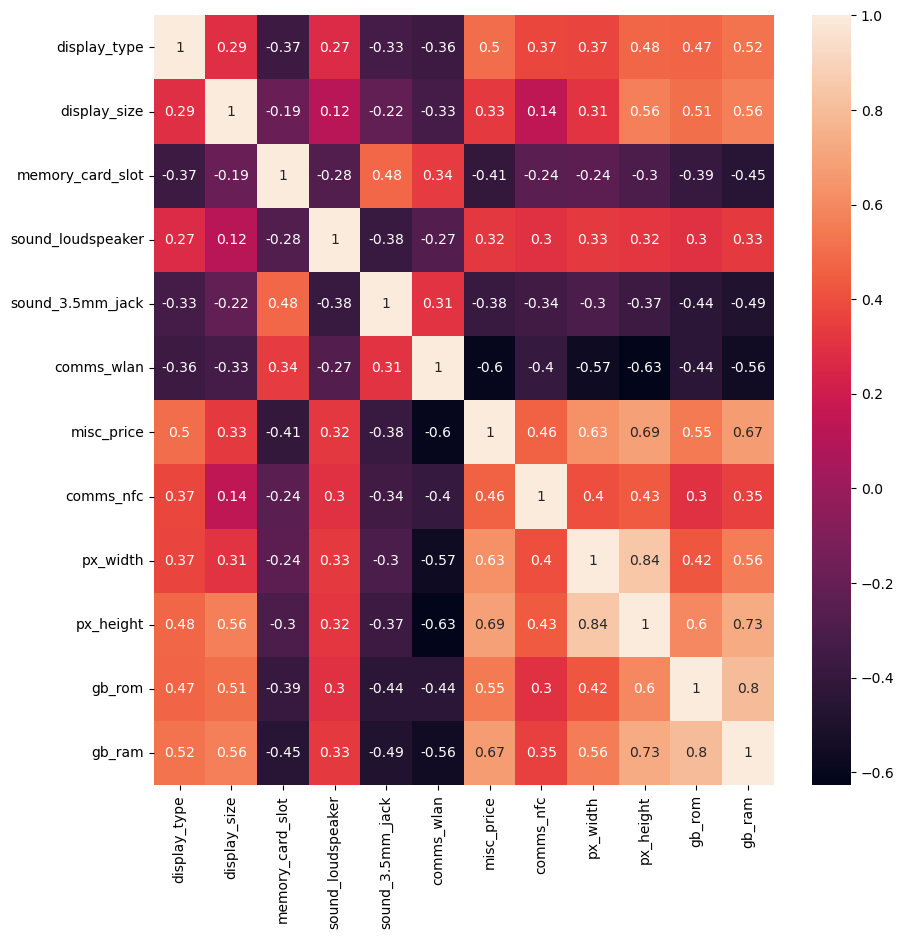

In [39]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [20]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["misc_price"]), df.misc_price, test_size=0.15, random_state=42)

In [21]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (989, 11), X_test: (248, 11), y_train: (989,), y_test: (248,)


In [22]:
# one-hot encoding of y_train and y_test
onehot = OneHotEncoder(sparse_output=False)
y_train = onehot.fit_transform(y_train.values.reshape(-1, 1))
y_test = onehot.transform(y_test.values.reshape(-1, 1))

In [23]:
# split train set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}")

X_train: (791, 11), X_val: (198, 11), y_train: (791, 5), y_val: (198, 5)


In [24]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", num_class=len(labels), random_state=42)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)

c:\Users\andre\miniconda3\envs\master-aiii\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBoostError: [20:10:46] D:\bld\xgboost-split_1679035243975\work\include\xgboost/objective.h:98: multioutput is not supported by current objective function

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = xgb_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")